# Labels and shapes interchangeability

This tutorial, showcases the following:
1. Vectorization, i.e. the convertion of labels into shapes
2. Rasterization, i.e. the convertion of shapes (or points) into labels

In [18]:
import spatialdata_plot
from spatialdata import rasterize, to_circles, to_polygons
from spatialdata.datasets import blobs

In [2]:
sdata = blobs()
sdata

/opt/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/operations/aggregate.py:259: UserWarning: Converting `region_key: region` to categorical dtype.
  table = TableModel.parse(table, region=shapes_name, region_key=region_key, instance_key=instance_key)


SpatialData object with:
├── Images
│     ├── 'blobs_image': SpatialImage[cyx] (3, 512, 512)
│     └── 'blobs_multiscale_image': MultiscaleSpatialImage[cyx] (3, 512, 512), (3, 256, 256), (3, 128, 128)
├── Labels
│     ├── 'blobs_labels': SpatialImage[yx] (512, 512)
│     └── 'blobs_multiscale_labels': MultiscaleSpatialImage[yx] (512, 512), (256, 256), (128, 128)
├── Points
│     └── 'blobs_points': DataFrame with shape: (<Delayed>, 4) (2D points)
├── Shapes
│     ├── 'blobs_circles': GeoDataFrame shape: (5, 2) (2D shapes)
│     ├── 'blobs_multipolygons': GeoDataFrame shape: (2, 1) (2D shapes)
│     └── 'blobs_polygons': GeoDataFrame shape: (5, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (26, 3)
with coordinate systems:
▸ 'global', with elements:
        blobs_image (Images), blobs_multiscale_image (Images), blobs_labels (Labels), blobs_multiscale_labels (Labels), blobs_points (Points), blobs_circles (Shapes), blobs_multipolygons (Shapes), blobs_polygons (Shapes)

## Labels vectorization

Each label value (i.e., an integer value > 0) will be converted into a `shapely` `Polygon` or `MultiPolygon`.

In [3]:
sdata["vectorized"] = to_polygons(sdata["blobs_labels"])

Let's visualize the vectorized outline (black) on top of the raster labels (colored).

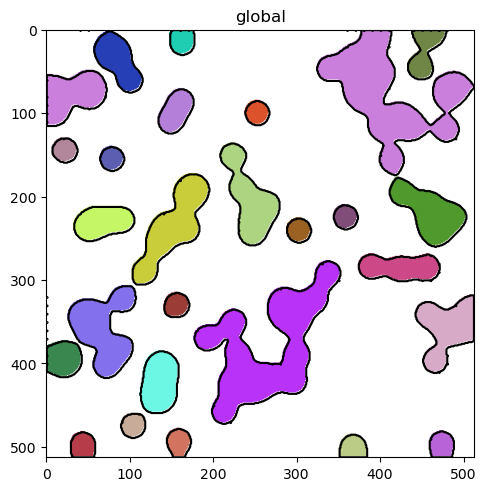

In [4]:
sdata.pl.render_labels().pl.render_shapes("vectorized", outline=True, fill_alpha=0).pl.show()

## Rasterization

Rasterization consist in creating a 2D image representing geometries (polygons / multipolygons / points in this tutorial).

### Shapes rasterization

We want to transform the following polygons into images:

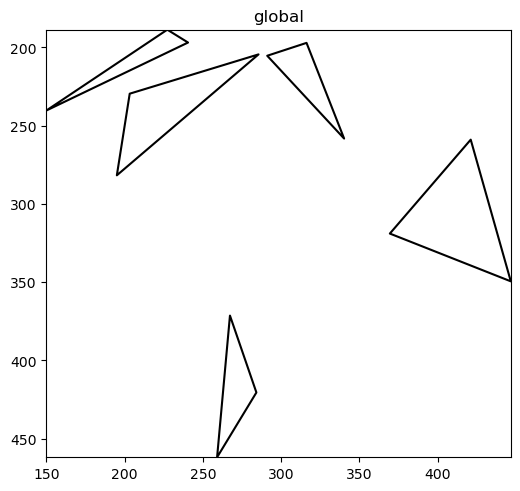

In [5]:
sdata.pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

Here, by default, we "count" the shapes. I.e., it will produce an image of shape `(1, y, x)` with zeros where there is no shape, ones where there is one shape, two if two shapes overlap, and so on.

In [6]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[0, 0],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    target_unit_to_pixels=1.0,
)

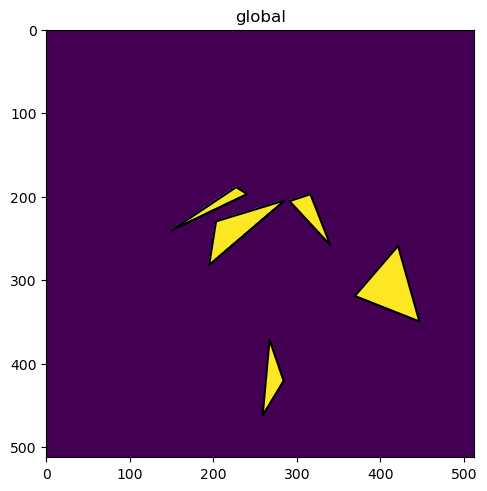

In [7]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

The argument `target_unit_to_pixels` is the ratio between the unit of the coordinate system and the resulting image size. Here, we set `target_unit_to_pixels=0.1`, which consequently divides by 10 the image size (and resolution):

In [23]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    target_unit_to_pixels=0.1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `rasterized` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


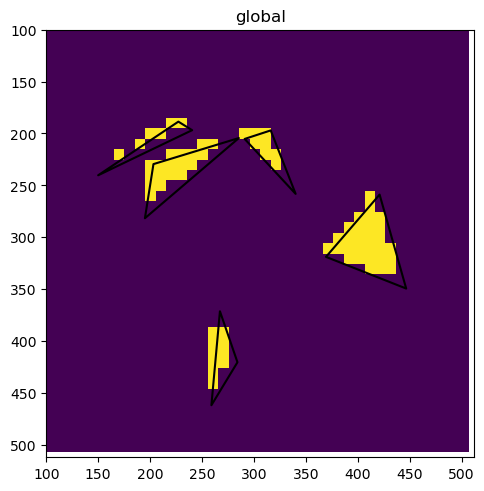

In [24]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

*Please note that in the above image the rasterized shapes show a pixel offset; this is a known bug that is tracked here: https://github.com/scverse/spatialdata/issues/165.*

With the rasterization below, we don't retain the ID of each shape. To have separated values for each shape, we can use `instance_key_as_default_value_key=True`. The first shape will be rasterized with ones, the second shape with 2, and so on.

Note that, in case two shapes overlap, only the first one is kept. If the shapes are highly overlapping, it is therefore recommended to use a different rasterization choice, shown later.

In [25]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    instance_key_as_default_value_key=True,
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `rasterized` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


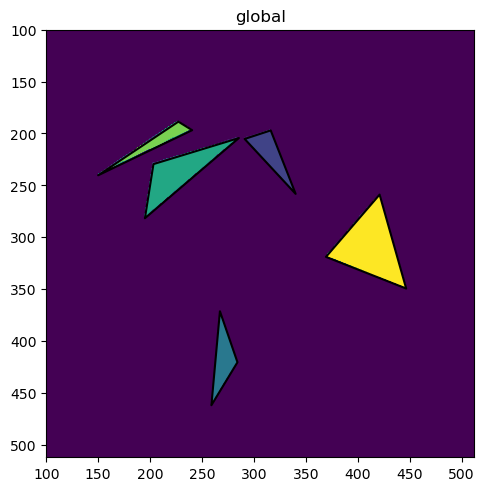

In [26]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

When shapes are highly overlapping, the previous rasterization will result in information lost. Therefore, we provide `return_single_channel=False` below to create an image of shape `(c, y, x)`, where `c` is the number of different shapes to be rasterized. This way, we ensure no information is lost, and each channel will correspond to one shape. 

Please consider that this increases the size of the returned object, it is therefore recommended to use this strategy when only a small number of shapes to rasterize is present (e.g. a few large anatomical annotations, as opposed to a large collection of cells). When instead large collection of shapes is to be rasterized, we recommend to call `rasterize()` multiple times, each time around a crop around the shape.

In [27]:
sdata["rasterized"] = rasterize(
    sdata["blobs_polygons"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    target_coordinate_system="global",
    instance_key_as_default_value_key=True,
    return_single_channel=False,
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `rasterized` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


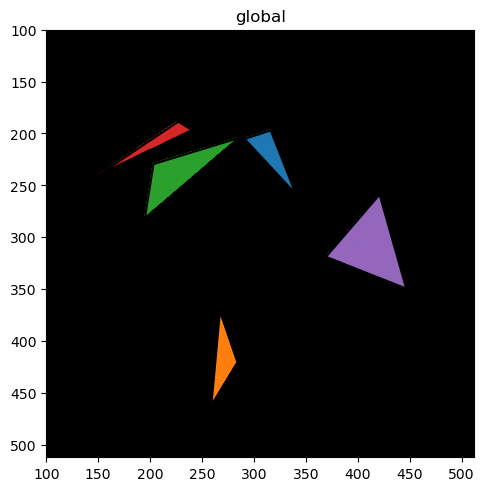

In [28]:
sdata.pl.render_images("rasterized").pl.render_shapes("blobs_polygons", outline=True, fill_alpha=0).pl.show()

### Points rasterization

Points, for instance transcripts, can also be rasterized.

A simple case is to count the transcripts:

In [14]:
sdata["rasterized"] = rasterize(
    sdata["blobs_points"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    value_key="genes",
    target_coordinate_system="global",
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `rasterized` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


Each pixel intensity represents the number of transcripts at this specific location. Here, the image have a shape `(1, y, x)`, i.e. all points are rasterized into one single channel.

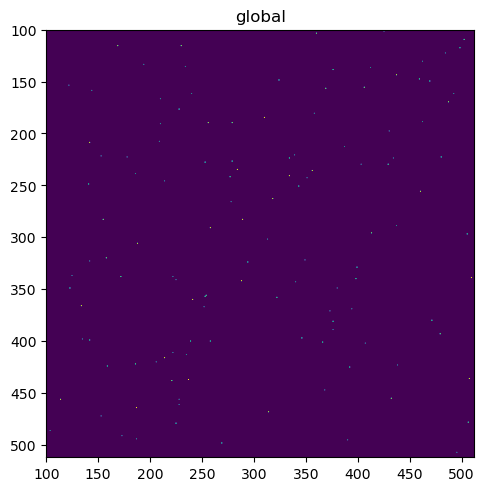

In [15]:
sdata.pl.render_images("rasterized").pl.show()

It's also possible to rasterize points that are grouped into different categories. For instance, below we rasterize transcripts for each gene.
For that, we provided `value_key="genes"` to denote that the column `"genes"` from `sdata["blobs_points"]` contains the genes names. It will output an image of shape `(c, y, x)`, where `c` is the number of different genes.

In [16]:
sdata["rasterized"] = rasterize(
    sdata["blobs_points"],
    ["x", "y"],
    min_coordinate=[100, 100],
    max_coordinate=[512, 512],
    value_key="genes",
    return_single_channel=False,
    target_coordinate_system="global",
    target_unit_to_pixels=1,
)

/Users/macbook/embl/projects/basel/spatialdata/src/spatialdata/_core/_elements.py:54: UserWarning: Key `rasterized` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


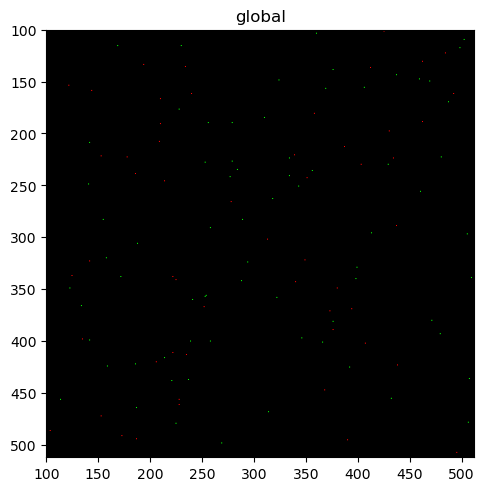

In [17]:
sdata.pl.render_images("rasterized").pl.show()